# Community Detection with Label Propagation 
---

## Introduction

Community detection is an unsupervised learning task that identifies
groups of nodes in a graph such that connections are dense within groups
and sparse between groups.

Unlike clustering in Euclidean feature space, community detection operates
on **graph connectivity**, not distances between feature vectors.

In this notebook, we apply **Label Propagation**, a classic community
detection algorithm, using a fully from-scratch implementation from the
`rice_ml` package.

---

## Mathematical Intuition Behind Community Detection

A graph is defined by:

- A set of nodes $V$
- A set of edges $E$ connecting pairs of nodes

The goal of community detection is to partition nodes into groups
(communities) such that:

- Nodes within the same community are highly connected
- Nodes in different communities have relatively few connections

---

### Label Propagation Algorithm

Label Propagation is an iterative algorithm defined as follows:

1. Assign each node a **unique label**
2. At each iteration, update each node’s label to the **most frequent label
   among its neighbors**
3. Repeat until labels no longer change

For node $i$, the update rule is:

$$
\ell_i^{(t+1)} = \arg\max_{\ell} \sum_{j \in N(i)} \mathbf{1}(\ell_j^{(t)} = \ell)
$$

where:
- $N(i)$ is the neighborhood of node $i$
- $\ell_i$ is the label of node $i$

Labels diffuse through densely connected regions, causing communities to
emerge naturally.

---

## Dataset Overview (UCI)

This demo uses three files from the **Facebook Large Page-Page Network** dataset (UCI ID 527).
Each file contributes different information.

### `musae_facebook_edges.csv`

This is the primary file used for community detection.

- Undirected edge list  
- Each row represents a connection between two Facebook pages  
- Columns:
  - `id_1` — first node (integer, zero-based)
  - `id_2` — second node (integer, zero-based)
- Node IDs are consecutive integers starting from 0 (for the full dataset)

This file defines the graph structure on which label propagation is applied.

### `musae_facebook_features.json`

This file contains node-level features.

- One record per node
- Features represent words appearing in page descriptions (bag-of-words style)
- These features are not used directly in label propagation (LPA relies only on edges),
  but they can be used for extended analyses such as:
  - Community characterization
  - Node classification
  - Feature-driven clustering

### `musae_facebook_target.csv`

This file provides node-level labels / metadata.

- One row per node
- Includes a page identifier and a category/class label

These labels allow for:
- Evaluating whether detected communities align with real categories
- Coloring nodes by known labels for interpretation

---

In [41]:
import io
import zipfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.unsupervised_learning.community_detection import LabelPropagation

In [42]:
UCI_ZIP_URL = "https://archive.ics.uci.edu/static/public/527/facebook%2Blarge%2Bpage%2Bpage%2Bnetwork.zip"

with urllib.request.urlopen(UCI_ZIP_URL) as resp:
    zip_bytes = resp.read()

z = zipfile.ZipFile(io.BytesIO(zip_bytes))

# Load edges
with z.open("facebook_large/musae_facebook_edges.csv") as f:
    edges = pd.read_csv(f)

# Load targets
with z.open("facebook_large/musae_facebook_target.csv") as f:
    targets = pd.read_csv(f)

edges.head(), targets.head()

(   id_1   id_2
 0     0  18427
 1     1  21708
 2     1  22208
 3     1  22171
 4     1   6829,
    id       facebook_id                                     page_name  \
 0   0   145647315578475                      The Voice of China 中国好声音   
 1   1      191483281412                 U.S. Consulate General Mumbai   
 2   2   144761358898518                                          ESET   
 3   3   568700043198473  Consulate General of Switzerland in Montreal   
 4   4  1408935539376139             Mark Bailey MP - Labor for Miller   
 
     page_type  
 0      tvshow  
 1  government  
 2     company  
 3  government  
 4  politician  )

### Interpretation

We now have:
- edges: the graph structure
- targets: category labels for interpretation (not required for the algorithm)
- features.json: available for extensions but not required in this notebook

## Exploratory Data Analysis (EDA)

### Basic Graph Statistics

In [43]:
n_nodes = int(max(edges["id_1"].max(), edges["id_2"].max()) + 1)
n_edges = len(edges)

n_nodes, n_edges


(22470, 171002)

In [44]:
deg = np.zeros(n_nodes, dtype=int)
for u, v in edges[["id_1", "id_2"]].itertuples(index=False):
    deg[u] += 1
    deg[v] += 1

deg.min(), deg.max(), deg.mean()

(np.int64(1), np.int64(709), np.float64(15.220471740097908))

### Interpretation

The degree distribution in social networks is typically heavy-tailed:
a small number of nodes (hubs) have many connections. These hubs often sit
at the center of dense substructures and are good candidates for extracting
an informative subgraph for visualization and community detection.

### Degree Histogram

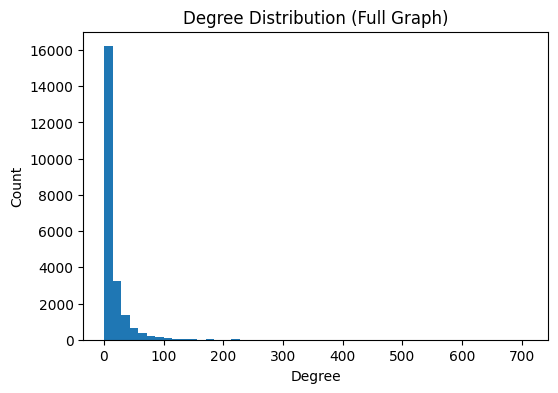

In [45]:
plt.figure(figsize=(6, 4))
plt.hist(deg, bins=50)
plt.title("Degree Distribution (Full Graph)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

### Interpretation

Most nodes have relatively small degree, while a few nodes have large degree.
This motivates extracting a subgraph of high-degree nodes that is:
- dense enough to contain community structure
- small enough to build an adjacency matrix and visualize

## Building a 500-node subgraph

To make the problem computationally manageable and easy to visualize, we restrict the analysis to a subgraph induced by 500 high-degree nodes.

Steps:

1. Compute the degree (number of incident edges) for each node in the graph.
2. Select the 500 nodes with the highest degree.
3. Retain only edges for which **both endpoints** belong to this selected
   node set, forming the induced subgraph.
4. Remap the selected node identifiers to a consecutive index set  
   $\{0, 1, \ldots, n-1\}$.
5. Construct a dense adjacency matrix  
   $A \in \{0, 1\}^{n \times n}$ representing the subgraph.

This subgraph preserves the most highly connected and structurally
informative portion of the network while enabling efficient matrix-based
community detection and visualization.


### 1. Compute Node Degrees

In [46]:
# Determine number of nodes from edge list
n_nodes = int(max(edges["id_1"].max(), edges["id_2"].max()) + 1)

# Initialize degree array
degrees = np.zeros(n_nodes, dtype=int)

# Count incident edges
for u, v in edges[["id_1", "id_2"]].itertuples(index=False):
    degrees[u] += 1
    degrees[v] += 1


### 2. Select the Top 500 High-Degree Nodes

In [47]:
top_k = 500

# Indices of nodes with highest degree
top_nodes = np.argsort(degrees)[-top_k:]
top_nodes_set = set(top_nodes.tolist())


### 3. Keep Only Edges Within the Selected Node Set

In [48]:
# Induced subgraph: keep edges where both endpoints are selected
mask = edges["id_1"].isin(top_nodes_set) & edges["id_2"].isin(top_nodes_set)
edges_sub = edges.loc[mask, ["id_1", "id_2"]].copy()

edges_sub.shape

(9634, 2)

### 4. Remap Node IDs to a Consecutive Index Set

In [49]:
# Map old node IDs to new indices {0, 1, ..., n-1}
old_to_new = {old_id: new_id for new_id, old_id in enumerate(sorted(top_nodes_set))}
n_sub = len(old_to_new)

# Apply mapping
u_new = edges_sub["id_1"].map(old_to_new).to_numpy()
v_new = edges_sub["id_2"].map(old_to_new).to_numpy()

### 5. Construct the Dense Adjacency Matrix

In [50]:
# Initialize adjacency matrix
A = np.zeros((n_sub, n_sub), dtype=int)

# Populate adjacency matrix
for u, v in zip(u_new, v_new):
    A[u, v] = 1
    A[v, u] = 1  # undirected graph

# Ensure no self-loops
np.fill_diagonal(A, 0)

A.shape


(500, 500)

## Community Detection via Label Propagation

Model Overview

We now apply Label Propagation (LPA) to the induced subgraph represented by
the adjacency matrix A.

Label Propagation is an unsupervised community detection algorithm that
identifies groups of nodes based solely on graph connectivity. Unlike
clustering methods in feature space, LPA does not rely on distances, centroids,
or density thresholds.

Instead, communities emerge through iterative majority voting among neighbors.

### Algorithm Recap

The algorithm proceeds as follows:

Assign each node a unique label.

For each node, examine the labels of its neighbors.

Update the node’s label to the most frequent neighbor label.

Repeat until labels stabilize or a maximum number of iterations is reached.

Dense regions of the graph reinforce a common label, causing communities
to form naturally.

In [51]:
lp = LabelPropagation(max_iter=100)
labels = lp.fit_predict(A)


## Understanding Community Labels

Community labels are categorical identifiers, not ordered values.

Label values (e.g., 0, 3, 7) have no intrinsic meaning

Only label equality matters

The number of unique labels corresponds to the number of detected communities

In [52]:
unique_labels, counts = np.unique(labels, return_counts=True)
community_sizes = dict(zip(unique_labels, counts))
community_sizes


{np.int64(10): np.int64(314),
 np.int64(12): np.int64(13),
 np.int64(13): np.int64(57),
 np.int64(17): np.int64(11),
 np.int64(26): np.int64(13),
 np.int64(30): np.int64(16),
 np.int64(38): np.int64(12),
 np.int64(40): np.int64(10),
 np.int64(70): np.int64(14),
 np.int64(78): np.int64(40)}

### Interpretation

The community size distribution provides insight into the structure of the graph:
- A small number of large communities suggests dominant hubs or themes
- Many small communities may indicate fragmented or localized connectivity
- Single-node communities may correspond to weakly connected or peripheral nodes

Because Label Propagation does not enforce a fixed number of communities,
this structure emerges entirely from the graph topology.

## Connectivity vs Communities

As a simple validation step, we compare node degree to community membership.

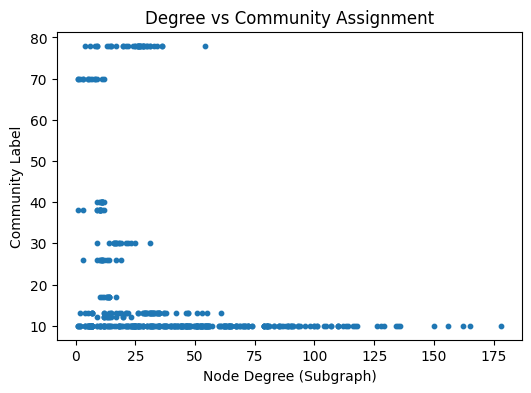

In [53]:
degrees_sub = A.sum(axis=1)

plt.figure(figsize=(6, 4))
plt.scatter(degrees_sub, labels, s=10)
plt.xlabel("Node Degree (Subgraph)")
plt.ylabel("Community Label")
plt.title("Degree vs Community Assignment")
plt.show()

### Interpretation

Highly connected nodes often serve as anchors for communities, while
low-degree nodes may attach to nearby communities or form small clusters.
This plot helps confirm that label propagation is responding to graph structure
rather than behaving randomly.

## Community Detection Visualization

After detecting communities using Label Propagation, we visualize the results
to understand the structure uncovered by the algorithm. Because community
detection operates on graphs rather than feature vectors, visualization is
performed using a **graph-based embedding** rather than the original data space.

We use a **spectral embedding** derived from the graph Laplacian to project
nodes into two dimensions.

---

### Graph Laplacian

Let $A$ be the adjacency matrix of the graph and let $D$ be the degree matrix,
where:

$$
D_{ii} = \sum_j A_{ij}
$$

The (unnormalized) graph Laplacian is defined as:

$$
L = D - A
$$

The eigenvectors of $L$ corresponding to its smallest nonzero eigenvalues
provide a low-dimensional representation that preserves graph connectivity.

---

### Compute the Laplacian


In [54]:
# Degree matrix
degrees_sub = A.sum(axis=1)
D = np.diag(degrees_sub)

# Graph Laplacian
L = D - A

### Spectral Embedding (2D)

We compute the eigen-decomposition of the Laplacian and use the two eigenvectors
associated with the smallest nonzero eigenvalues as coordinates.

In [55]:
# Eigen-decomposition
evals, evecs = np.linalg.eigh(L)

# Sort eigenvalues and eigenvectors
idx = np.argsort(evals)

# Skip the first eigenvector (corresponding to eigenvalue ~0)
coords = evecs[:, idx[1:3]]


## Visualizing Communities

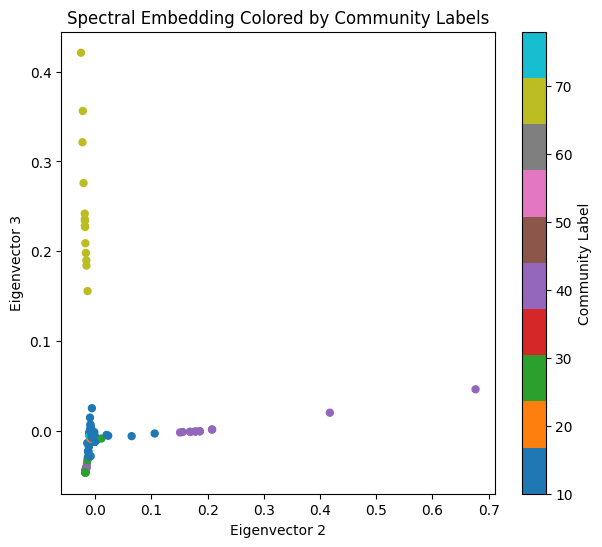

In [56]:
plt.figure(figsize=(7, 6))
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=labels,
    cmap="tab10",
    s=25
)
plt.title("Spectral Embedding Colored by Community Labels")
plt.xlabel("Eigenvector 2")
plt.ylabel("Eigenvector 3")
plt.colorbar(label="Community Label")
plt.show()


### Interpretation

Nodes belonging to the same community tend to cluster together in the spectral
embedding. This occurs because nodes that are densely connected share similar
Laplacian structure. The visualization provides a geometric interpretation of
community structure that is entirely derived from graph connectivity.

Unlike feature-space clustering, this embedding does not rely on node attributes
and reflects only the topology of the network.

## Stability Analysis of Label Propagation

Label Propagation is known to be sensitive to update order and randomness.
To assess the robustness of the detected communities, we perform a stability
analysis by rerunning the algorithm with different random seeds and measuring
the resulting number of communities.

### Randomized Label Propagation with Damping

We implement a randomized version of Label Propagation directly in the notebook.
At each update step, a node either:

Keeps its current label with probability $\alpha$ (damping), or

Updates its label based on neighbor majority vote

This reduces oscillations and allows us to study convergence behavior.

In [57]:
def label_propagation_random(A, max_iter=100, seed=0, damping=0.0):
    rng = np.random.default_rng(seed)
    n = A.shape[0]

    # Initialize unique labels
    labels = np.arange(n)

    for _ in range(max_iter):
        changed = False
        order = rng.permutation(n)

        for i in order:
            if rng.random() < damping:
                continue

            neighbors = np.where(A[i] > 0)[0]
            if len(neighbors) == 0:
                continue

            neighbor_labels = labels[neighbors]
            values, counts = np.unique(neighbor_labels, return_counts=True)

            max_count = counts.max()
            candidates = values[counts == max_count]
            new_label = candidates.min()  # deterministic tie-break

            if labels[i] != new_label:
                labels[i] = new_label
                changed = True

        if not changed:
            break

    return labels


### Run Stability Experiments Across Seeds

In [58]:
seeds = [0, 1, 2, 3, 4, 5]
damping = 0.1

results = []

for s in seeds:
    lab = label_propagation_random(A, max_iter=100, seed=s, damping=damping)
    num_communities = len(np.unique(lab))
    results.append((s, num_communities))

results


[(0, 11), (1, 9), (2, 11), (3, 10), (4, 11), (5, 10)]

### Visualizing Stability Results

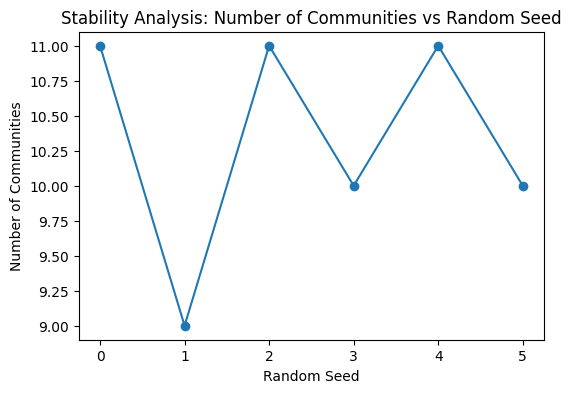

In [59]:
plt.figure(figsize=(6, 4))
plt.plot(
    [s for s, _ in results],
    [k for _, k in results],
    marker="o"
)
plt.title("Stability Analysis: Number of Communities vs Random Seed")
plt.xlabel("Random Seed")
plt.ylabel("Number of Communities")
plt.show()


### Interpretation

If the number of detected communities remains relatively consistent across
random seeds, the community structure is considered stable. Large variation
indicates that the graph admits multiple plausible partitions or that the
algorithm is sensitive to update order.

Introducing damping generally improves stability by preventing rapid label
oscillation, leading to more consistent solutions across runs.

## Comparison with DBSCAN (Conceptual)

The table below highlights the conceptual differences between DBSCAN and
community detection methods.

| Method | Input Representation | Groups Based On | Handles Noise |
|------|----------------------|----------------|---------------|
| DBSCAN | Feature space | Density | Yes |
| Community Detection | Graph | Connectivity | No |

DBSCAN identifies clusters based on spatial density in a feature space,
while community detection identifies structure based on connectivity
patterns in a graph.

## Limitations of Label Propagation

Label propagation may struggle when:

Graphs are very sparse

Community structure is weak

Multiple equally valid partitions exist

Because the algorithm is local and greedy, it may converge to different
solutions depending on update order.

## Conclusion

In this notebook, we demonstrated community detection via label
propagation using a fully from-scratch implementation.

Key takeaways:
- Community detection operates on graphs, not feature vectors
- Label propagation identifies communities through local consensus
- Dense connectivity naturally leads to stable community labels
- No prior knowledge of the number of communities is required

Together with DBSCAN, community detection provides a complementary
perspective on unsupervised structure discovery in data.